# Fraud Detection Model Training
This notebook trains an XGBoost model for real-time fraud detection

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

# Set style
sns.set_style('whitegrid')
%matplotlib inline

## 1. Generate Training Data

In [2]:
# Generate synthetic training data
from faker import Faker
import random
from datetime import datetime, timedelta

fake = Faker()
random.seed(42)
np.random.seed(42)

def generate_training_data(n_samples=10000, fraud_rate=0.05):
    data = []
    categories = ['grocery', 'restaurant', 'gas_station', 'online_retail', 'entertainment', 'travel', 'healthcare', 'utilities']
    
    for i in range(n_samples):
        is_fraud = random.random() < fraud_rate
        
        if is_fraud:
            amount = random.uniform(500, 5000)
            hour = random.choice([0, 1, 2, 3, 4, 23])
            category = random.choice(['online_retail', 'entertainment'])
        else:
            amount = random.uniform(5, 500)
            hour = random.randint(6, 22)
            category = random.choice(categories)
        
        transaction = {
            'amount': amount,
            'category': category,
            'hour': hour,
            'day_of_week': random.randint(0, 6),
            'latitude': float(fake.latitude()),
            'longitude': float(fake.longitude()),
            'is_fraud': int(is_fraud)
        }
        data.append(transaction)
    
    return pd.DataFrame(data)

# Generate data
df = generate_training_data(n_samples=10000)
print(f"Dataset shape: {df.shape}")
print(f"\nFraud distribution:")
print(df['is_fraud'].value_counts())
print(f"\nFraud rate: {df['is_fraud'].mean():.2%}")

Dataset shape: (10000, 7)

Fraud distribution:
is_fraud
0    9524
1     476
Name: count, dtype: int64

Fraud rate: 4.76%


## 2. Exploratory Data Analysis

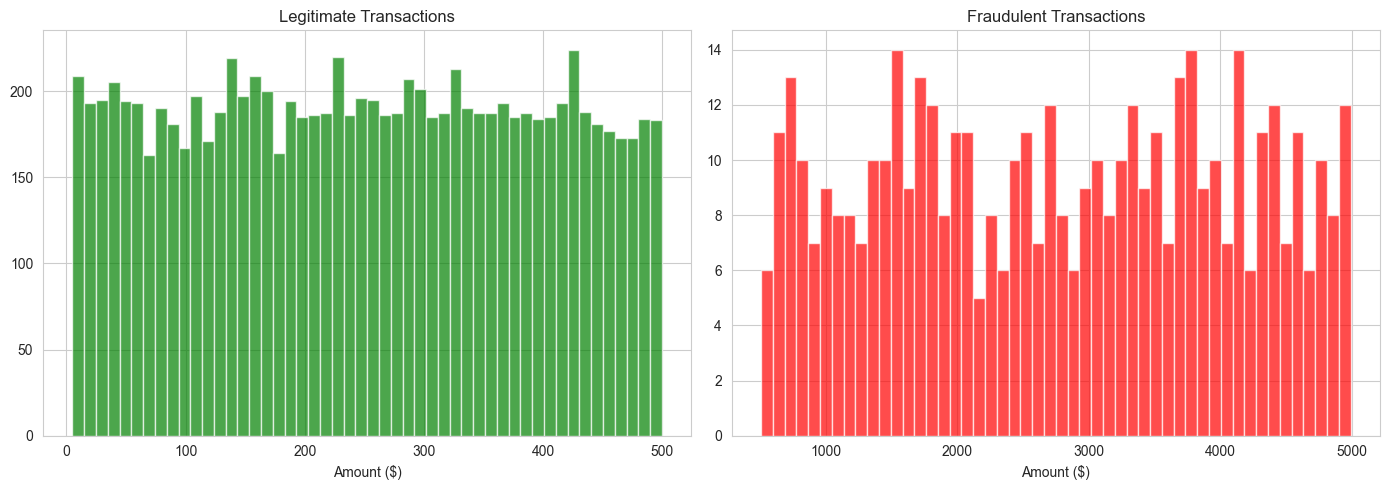

In [3]:
# Distribution of transaction amounts
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df[df['is_fraud']==0]['amount'].hist(bins=50, ax=axes[0], alpha=0.7, color='green')
axes[0].set_title('Legitimate Transactions')
axes[0].set_xlabel('Amount ($)')

df[df['is_fraud']==1]['amount'].hist(bins=50, ax=axes[1], alpha=0.7, color='red')
axes[1].set_title('Fraudulent Transactions')
axes[1].set_xlabel('Amount ($)')

plt.tight_layout()
plt.show()

## 3. Feature Engineering

In [4]:
# Encode categorical features
le = LabelEncoder()
df['category_encoded'] = le.fit_transform(df['category'])

# Feature engineering
df['is_night'] = (df['hour'] >= 22) | (df['hour'] <= 5)
df['is_weekend'] = df['day_of_week'].isin([5, 6])
df['amount_log'] = np.log1p(df['amount'])

# Select features
feature_cols = ['amount', 'amount_log', 'category_encoded', 'hour', 'day_of_week', 
                'is_night', 'is_weekend', 'latitude', 'longitude']

X = df[feature_cols]
y = df['is_fraud']

print(f"Features: {feature_cols}")
print(f"X shape: {X.shape}")

Features: ['amount', 'amount_log', 'category_encoded', 'hour', 'day_of_week', 'is_night', 'is_weekend', 'latitude', 'longitude']
X shape: (10000, 9)


## 4. Train-Test Split & Handle Imbalance

In [5]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTrain fraud rate: {y_train.mean():.2%}")
print(f"Test fraud rate: {y_test.mean():.2%}")

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"\nAfter SMOTE:")
print(f"Train set: {X_train_balanced.shape}")
print(f"Fraud rate: {y_train_balanced.mean():.2%}")

Train set: (8000, 9)
Test set: (2000, 9)

Train fraud rate: 4.76%
Test fraud rate: 4.75%

After SMOTE:
Train set: (15238, 9)
Fraud rate: 50.00%


## 5. Train XGBoost Model with MLflow

In [6]:
# Model parameters
params = {
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'scale_pos_weight': 1,
    'random_state': 42
}

# Train model
model = xgb.XGBClassifier(**params)
model.fit(X_train_balanced, y_train_balanced)

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Metrics
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"✅ Model trained with AUC: {auc_score:.4f}")

✅ Model trained with AUC: 1.0000


## 6. Model Evaluation

Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00      1905
       Fraud       1.00      1.00      1.00        95

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



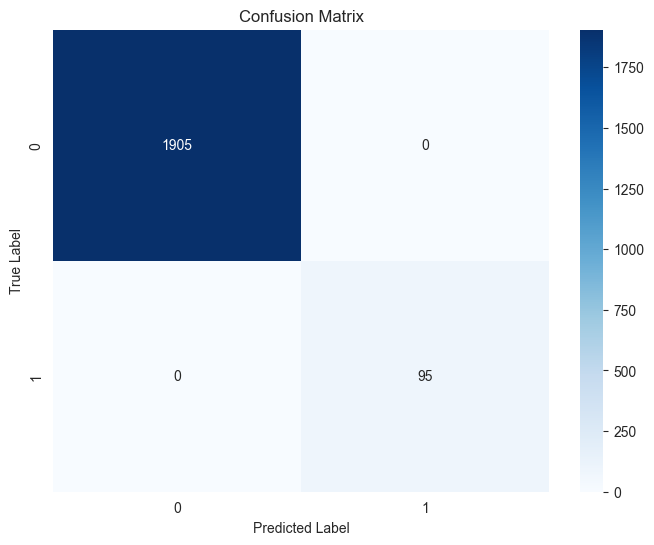

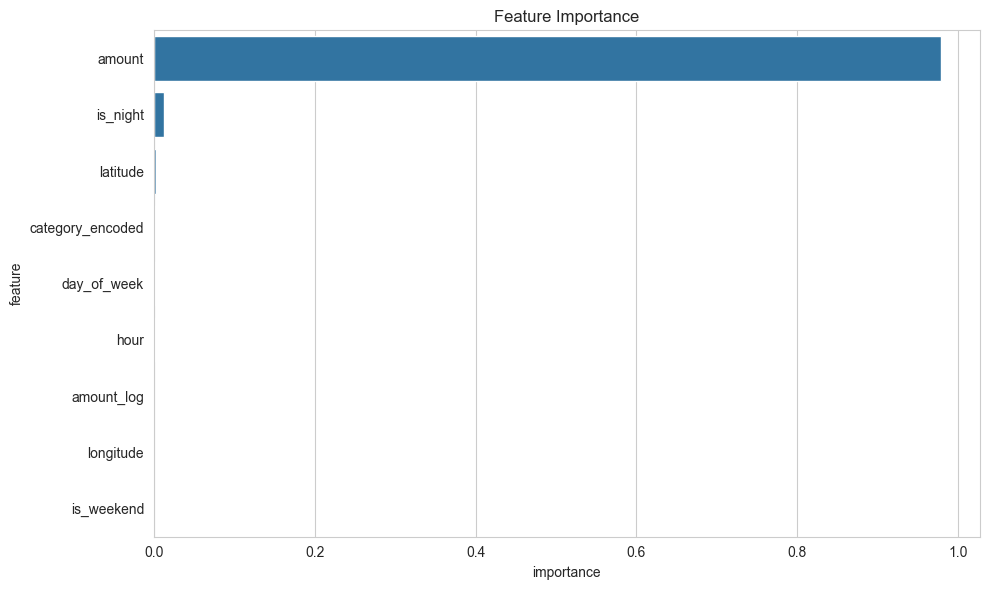

In [7]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Fraud']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

## 7. Save Model and Artifacts

In [8]:
# Save model
model_path = 'models/fraud_detector.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model, f)
print(f"✅ Model saved to {model_path}")

# Save label encoder
encoder_path = 'models/label_encoder.pkl'
with open(encoder_path, 'wb') as f:
    pickle.dump(le, f)
print(f"✅ Label encoder saved to {encoder_path}")

# Save feature names
feature_path = 'models/features.pkl'
with open(feature_path, 'wb') as f:
    pickle.dump(feature_cols, f)
print(f"✅ Features saved to {feature_path}")

✅ Model saved to models/fraud_detector.pkl
✅ Label encoder saved to models/label_encoder.pkl
✅ Features saved to models/features.pkl
